In [14]:
%matplotlib inline
import requests
import pandas
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc

In [3]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_style'), '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0])
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [4]:
def parse_finam_data(path):
    data = pandas.read_csv(path, dtype={'<DATE>': str, '<TIME>': str})
    data.columns = [c.replace('<','').replace('>','') for c in data.columns]
    data['DATETIME'] = pandas.to_datetime(data.DATE + data.TIME, format='%Y%m%d%H%M%S')
    data.drop('TICKER', axis=1, inplace=True)
    return data

In [5]:
fut = parse_finam_data('data\SPFB.SBRF-12.18_180901_181216.txt')
spot = parse_finam_data('data\SBER_180901_181216.txt')

In [6]:
fut.columns

Index(['PER', 'DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL',
       'DATETIME'],
      dtype='object')

In [7]:
price_columns = ['OPEN', 'HIGH', 'LOW', 'CLOSE']
for c in price_columns:
    spot[c] = spot[c]*100
merged = pandas.merge(fut.set_index('DATETIME')[price_columns],
                      spot.set_index('DATETIME')[price_columns],
                      on='DATETIME',
                      how='outer',
                      suffixes=('_fut', '_spot'))
merged = merged['2018-10-01':]
merged.sort_index(inplace=True)

In [8]:
gb = merged.groupby(by=lambda x: x.date())

2018-10-01
2018-10-02
2018-10-03
2018-10-04
2018-10-05
2018-10-08
2018-10-09
2018-10-10
2018-10-11
2018-10-12
2018-10-15
2018-10-16
2018-10-17
2018-10-18
2018-10-19
2018-10-22
2018-10-23
2018-10-24
2018-10-25
2018-10-26
2018-10-29
2018-10-30
2018-10-31
2018-11-01


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2018-11-02
2018-11-06
2018-11-07
2018-11-08
2018-11-09
2018-11-12
2018-11-13
2018-11-14
2018-11-15
2018-11-16
2018-11-19
2018-11-20
2018-11-21
2018-11-22
2018-11-23
2018-11-26
2018-11-27
2018-11-28
2018-11-29
2018-11-30
2018-12-03
2018-12-04
2018-12-05
2018-12-06
2018-12-07
2018-12-10
2018-12-11
2018-12-12
2018-12-13
2018-12-14


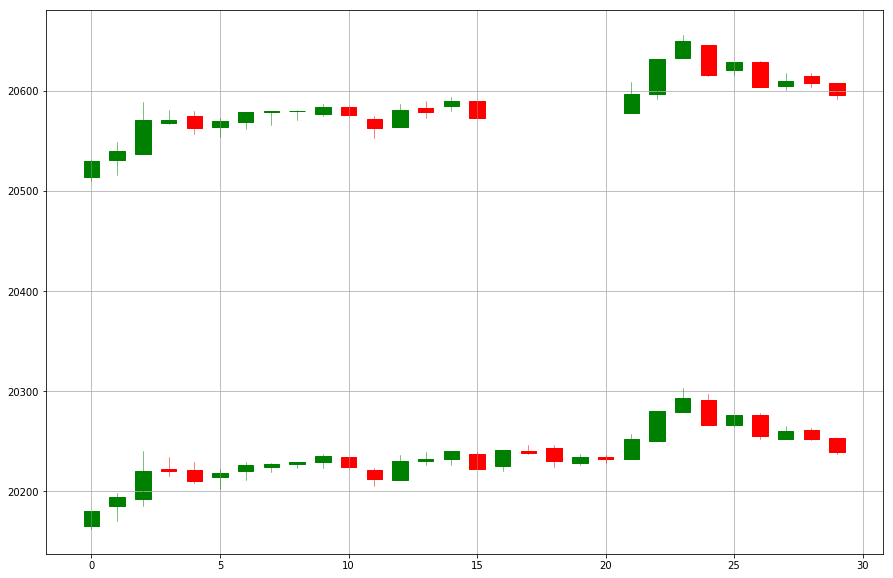

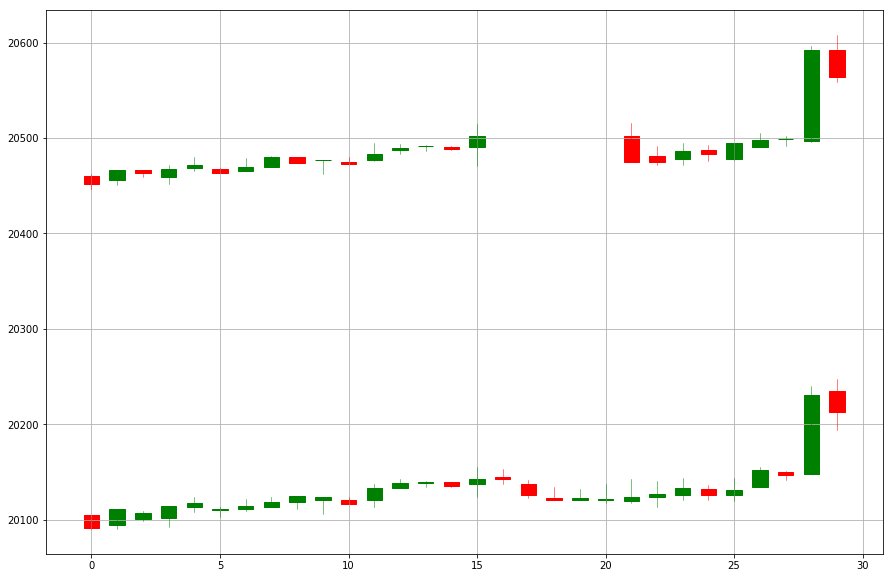

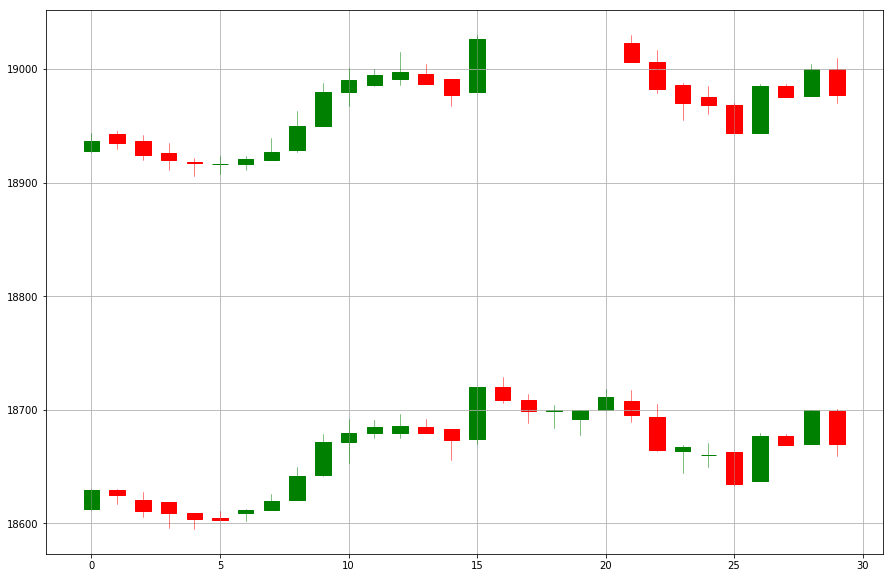

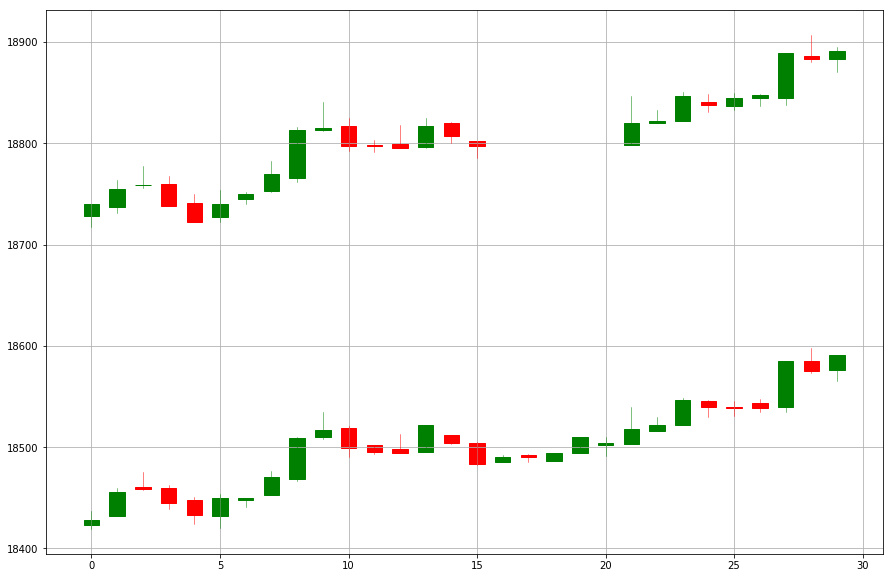

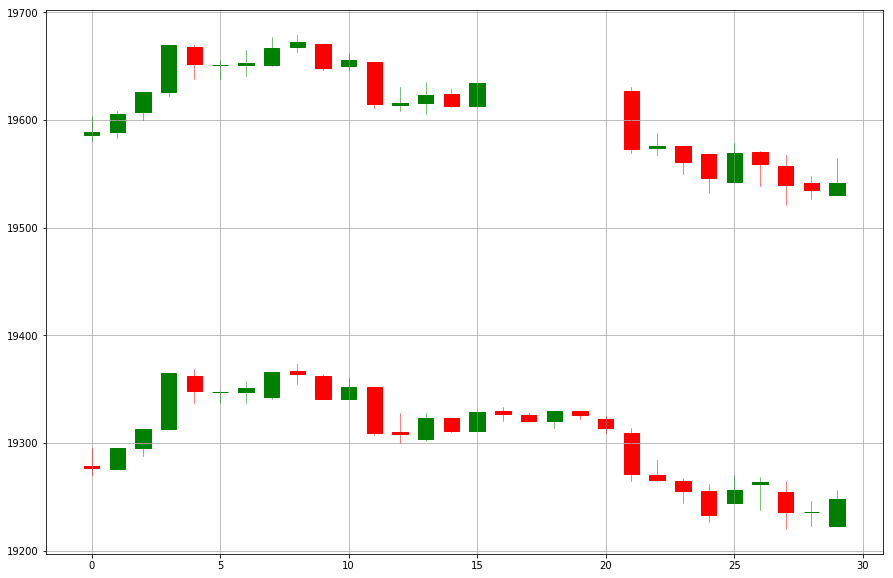

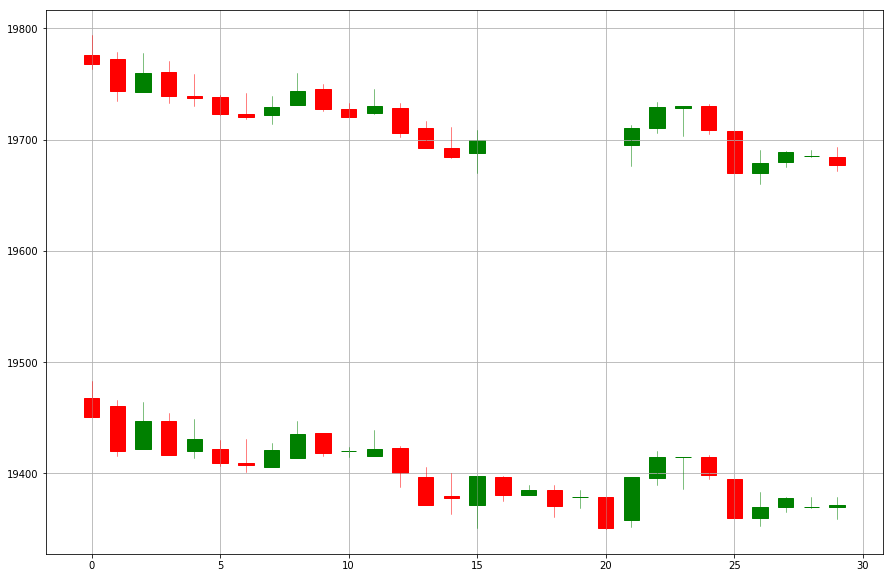

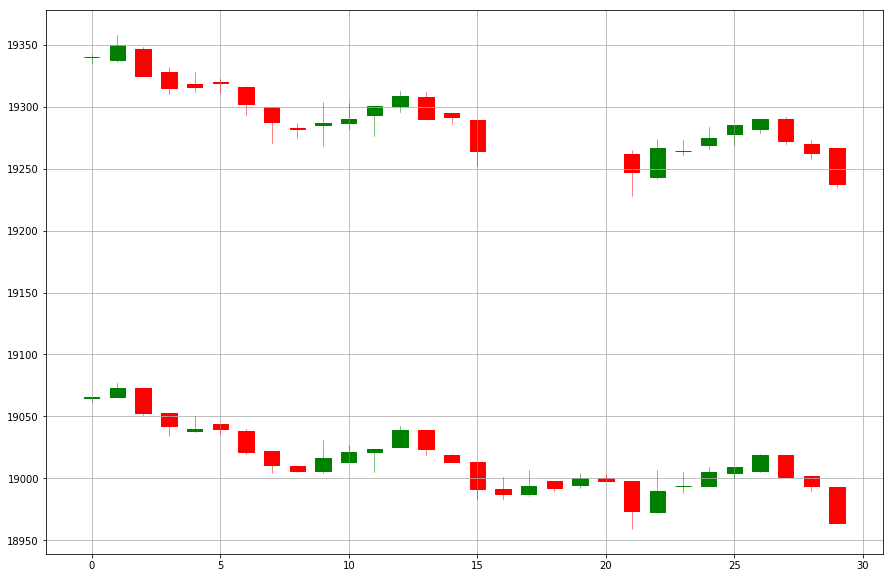

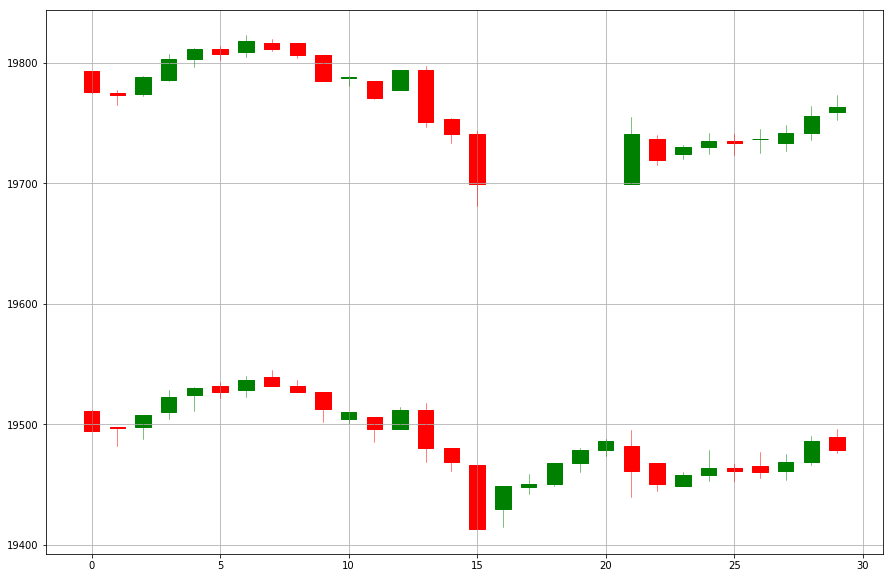

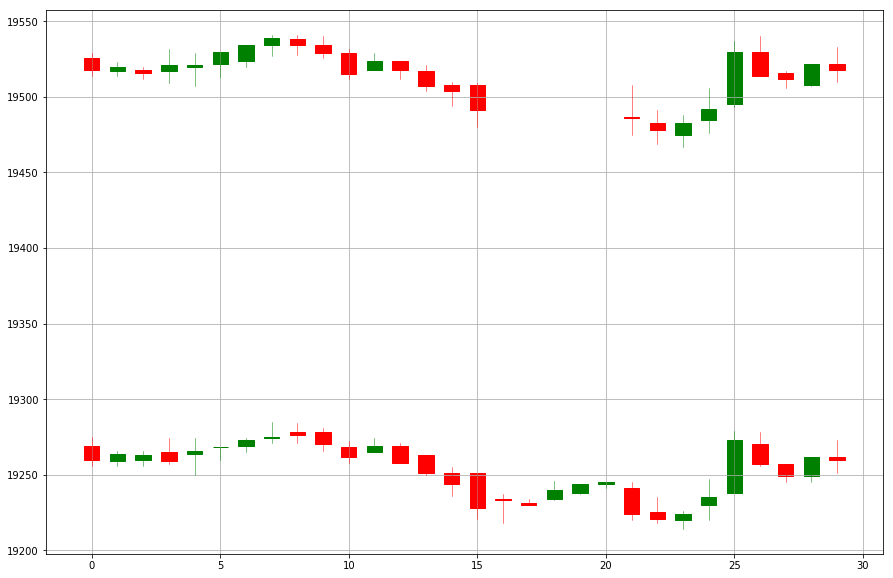

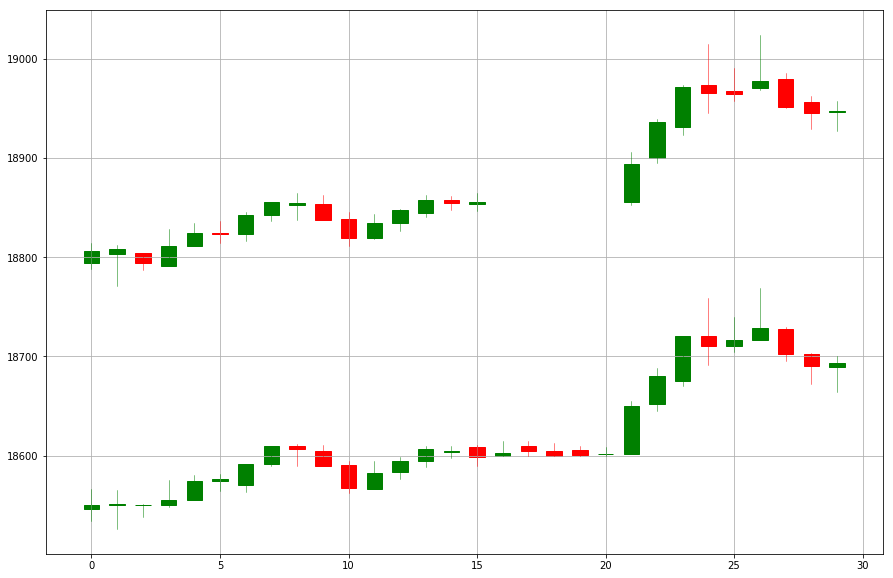

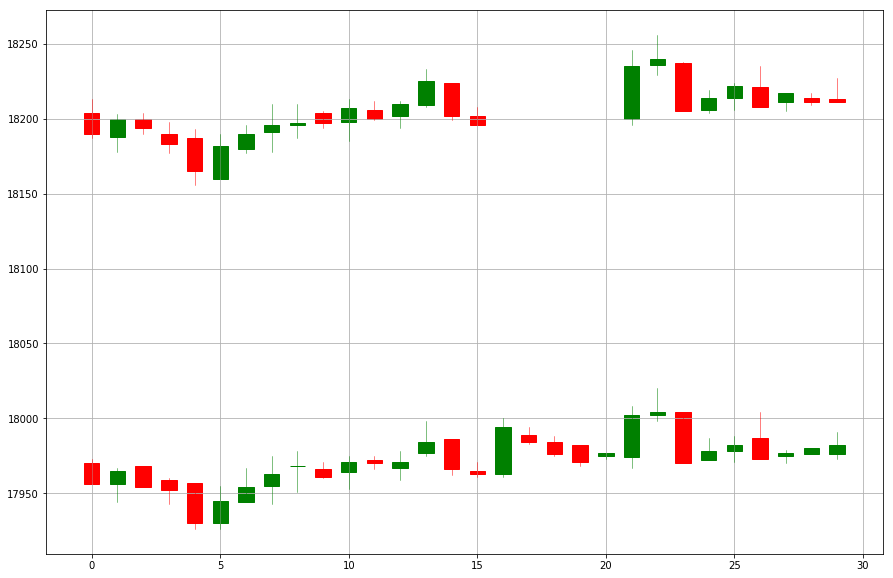

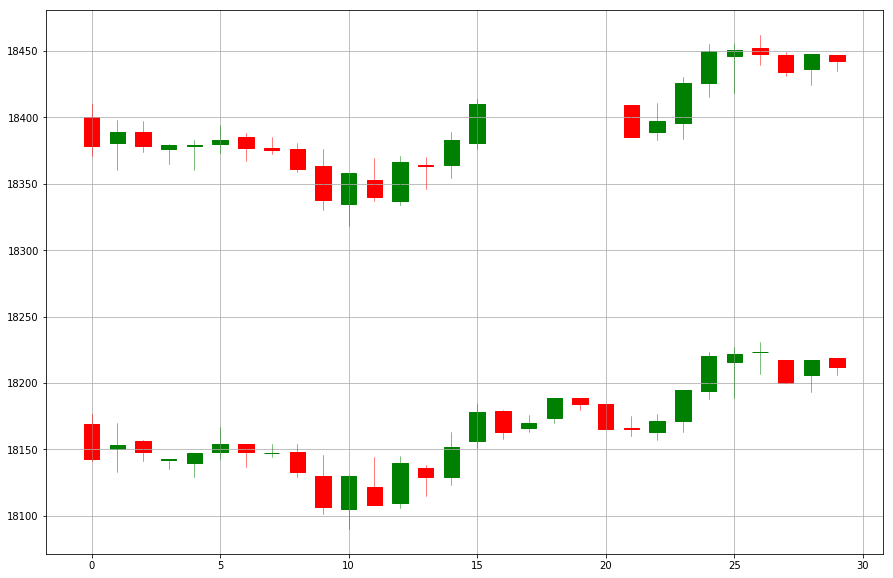

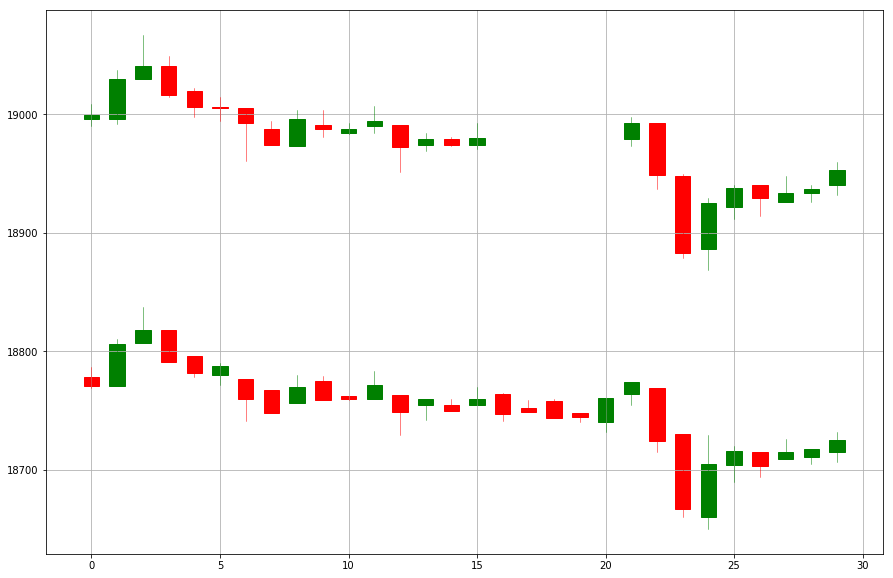

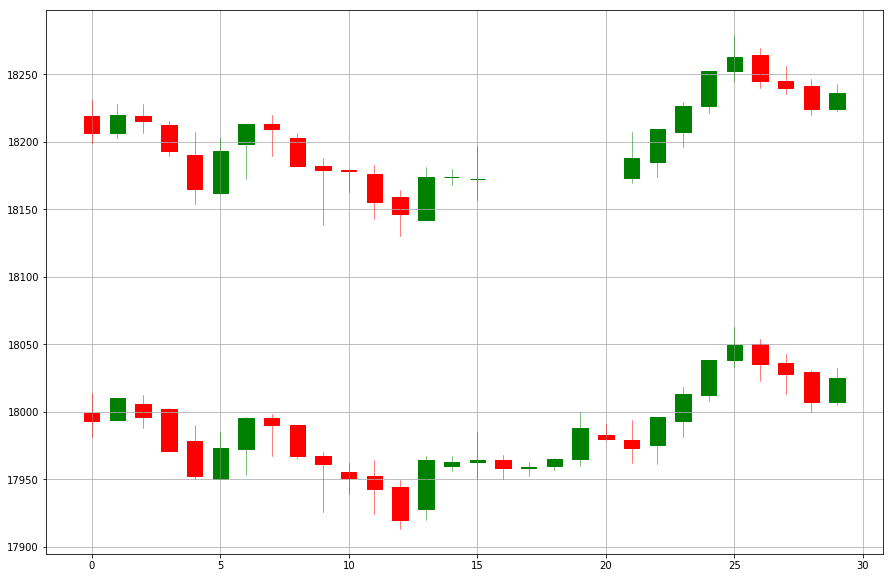

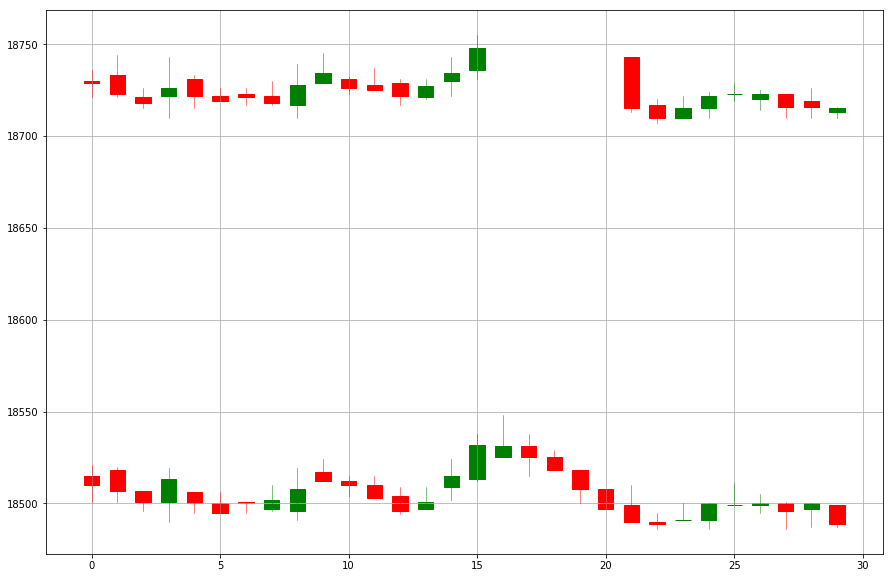

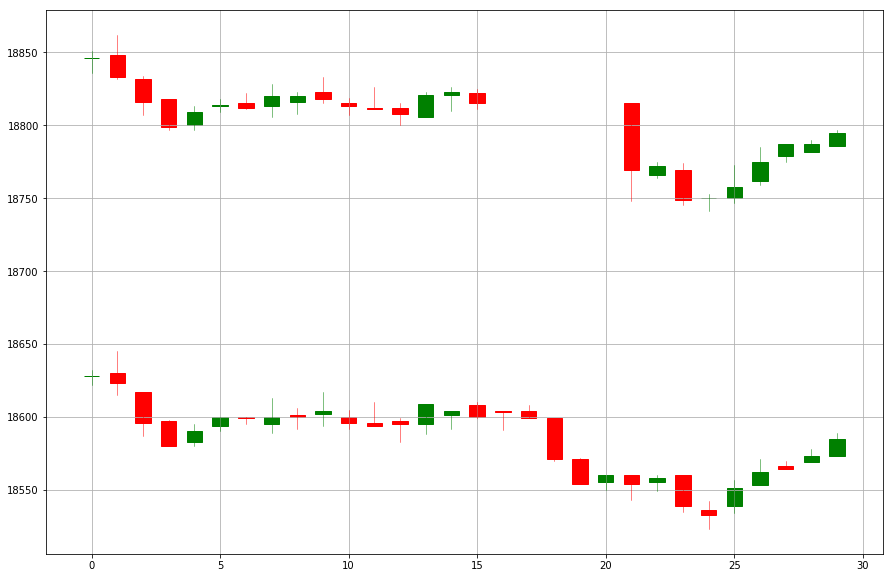

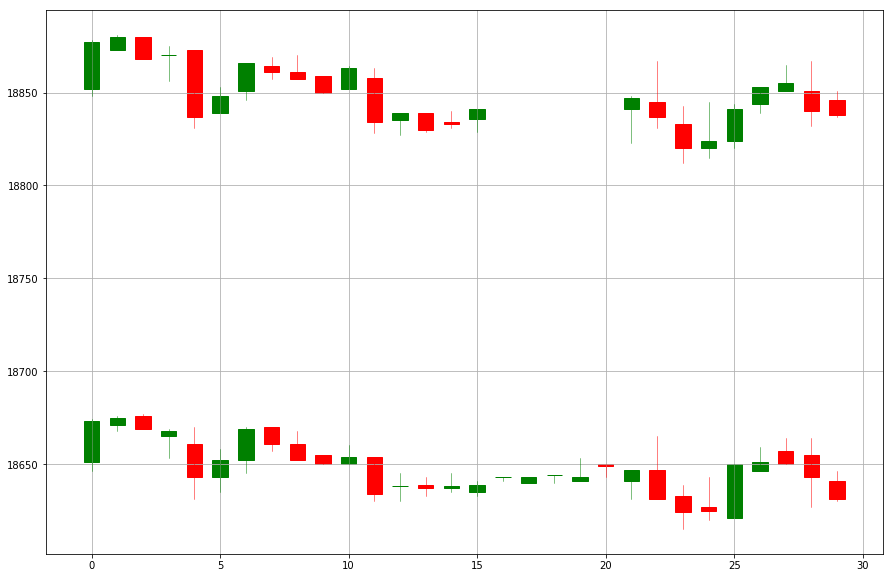

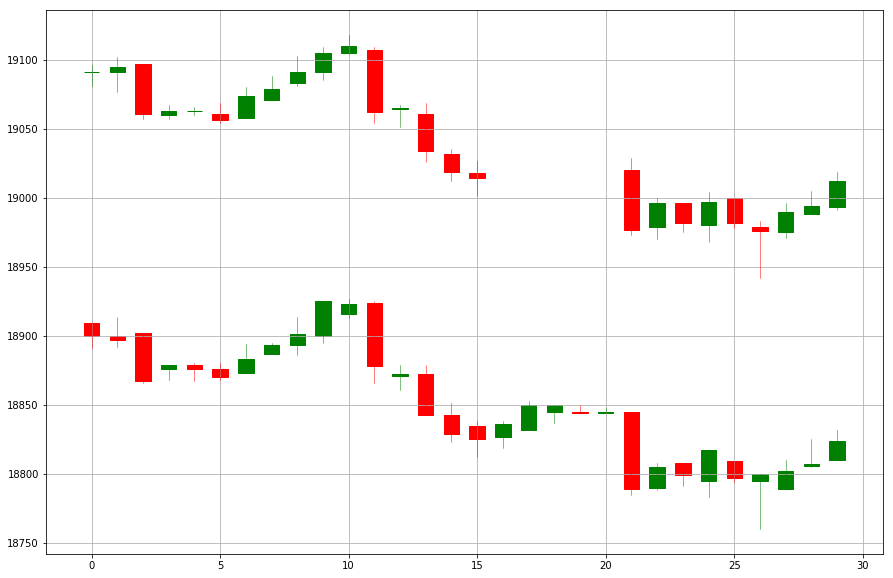

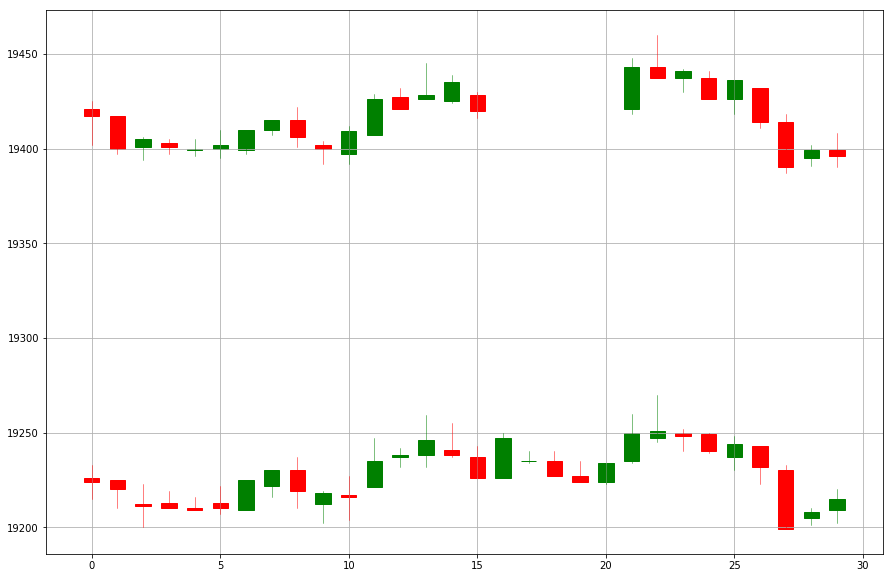

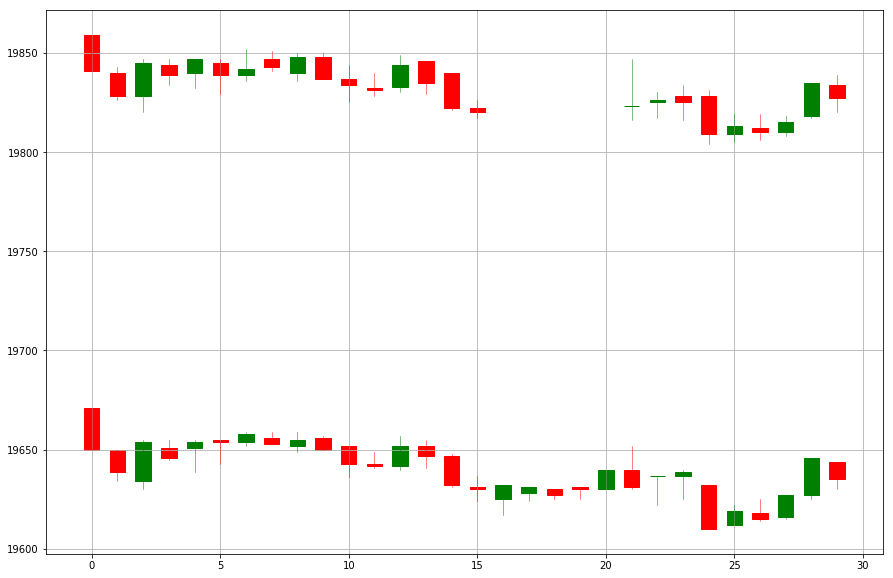

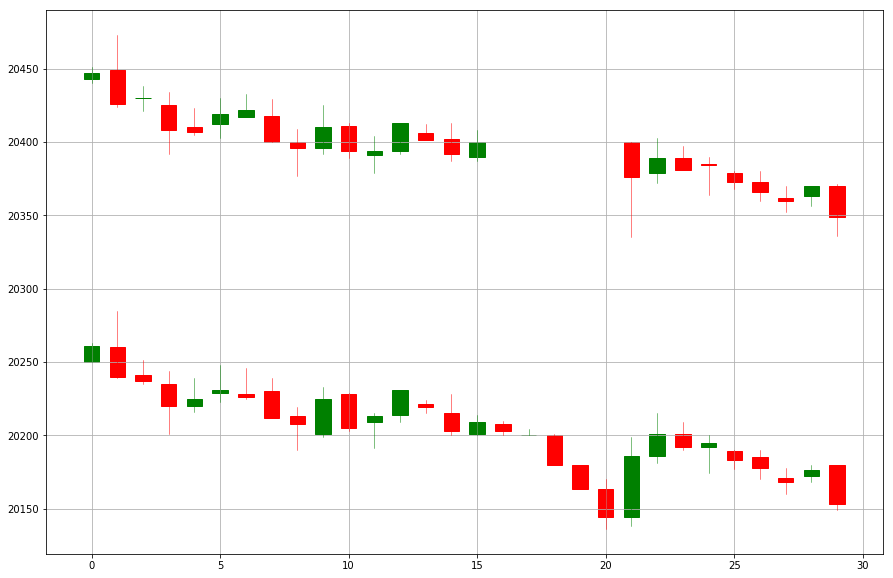

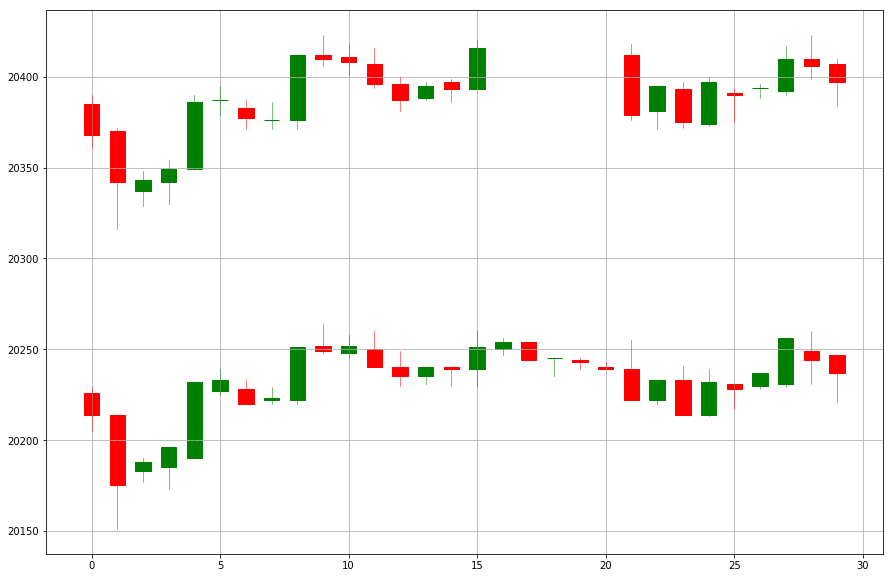

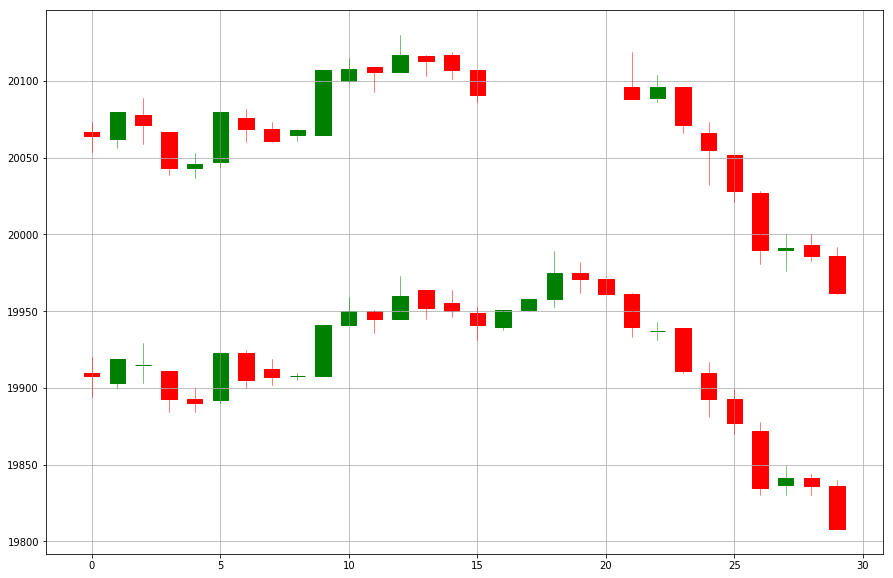

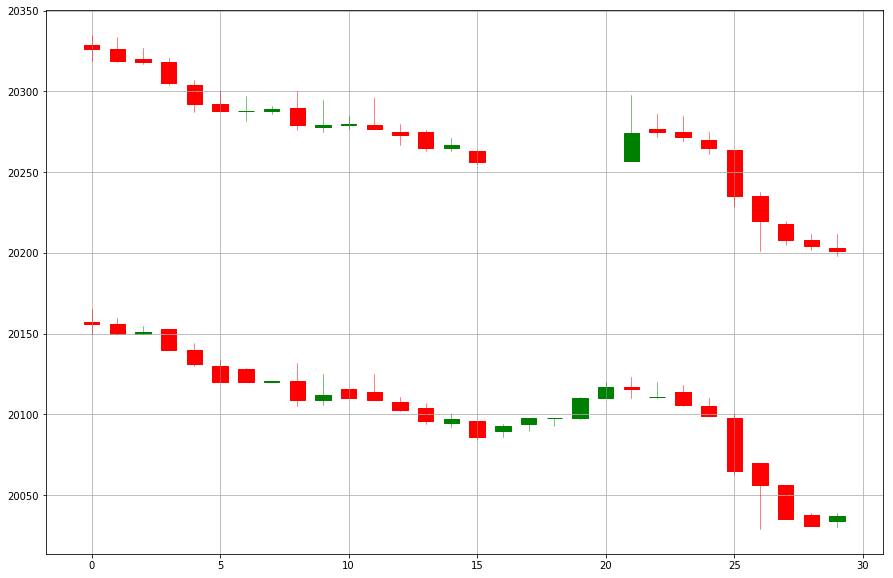

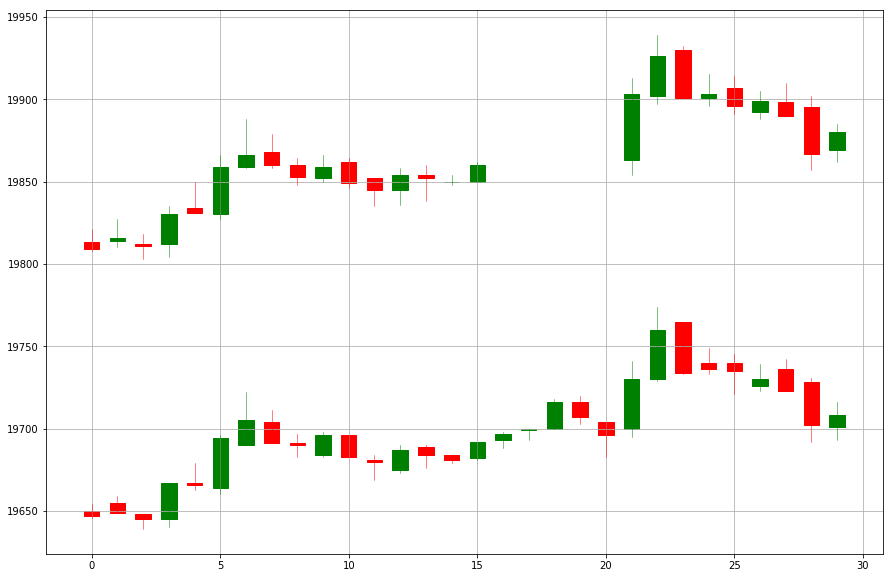

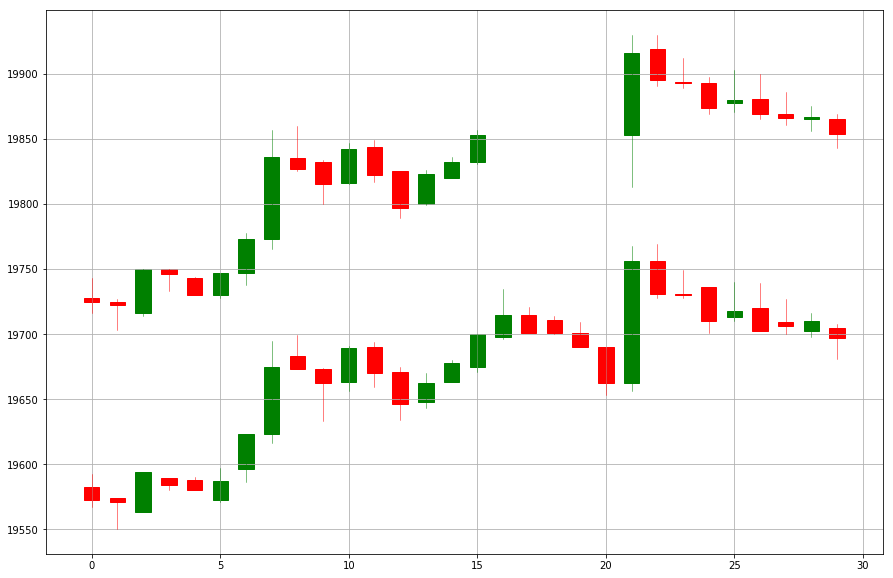

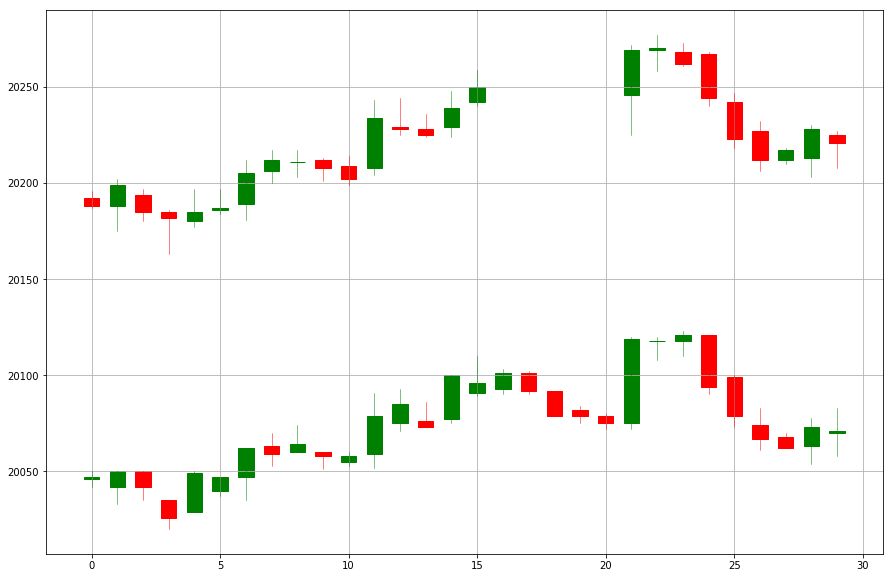

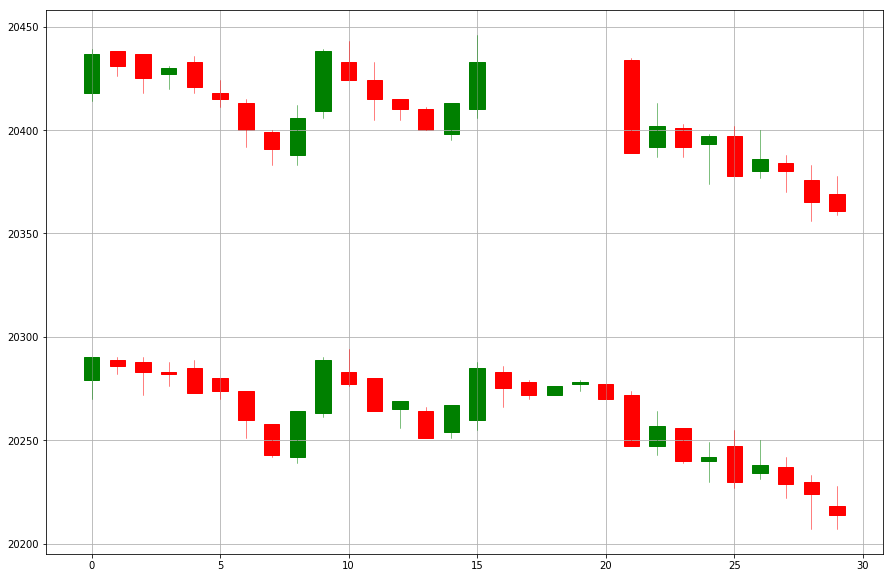

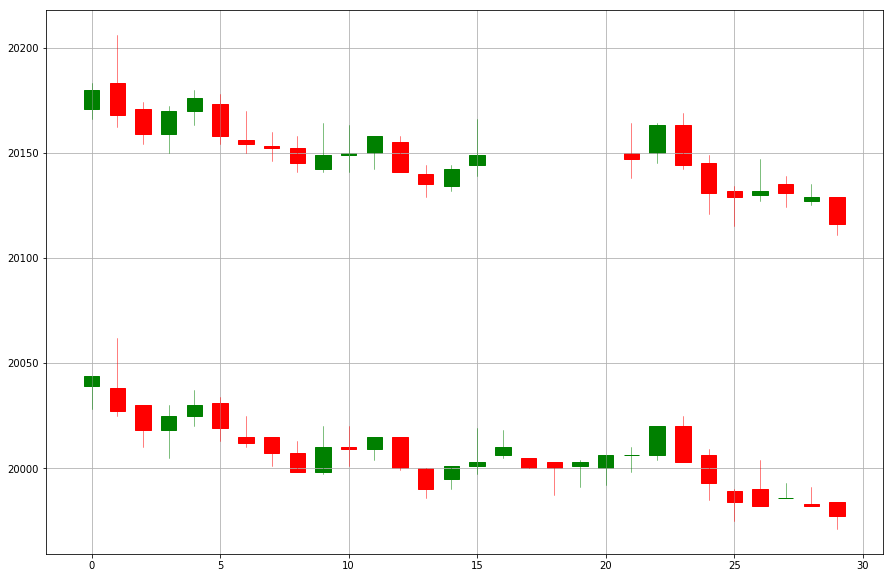

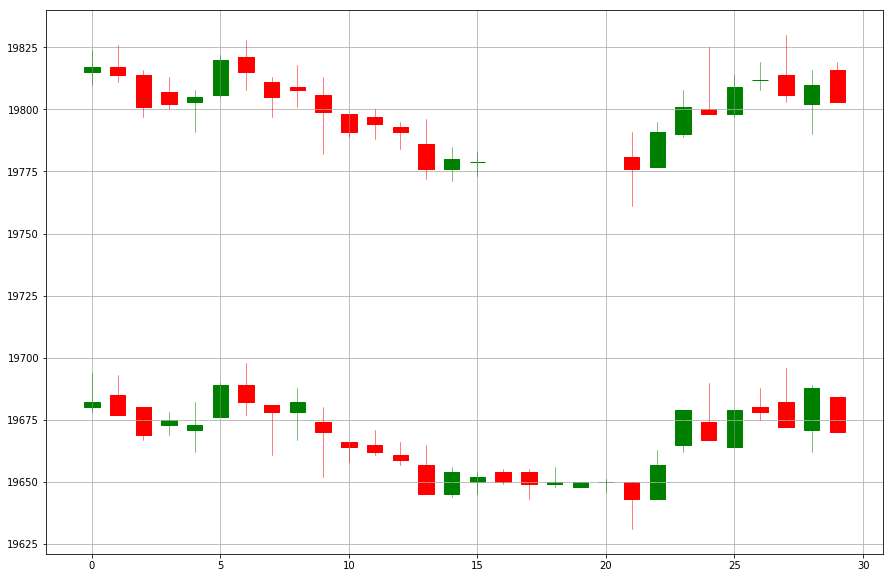

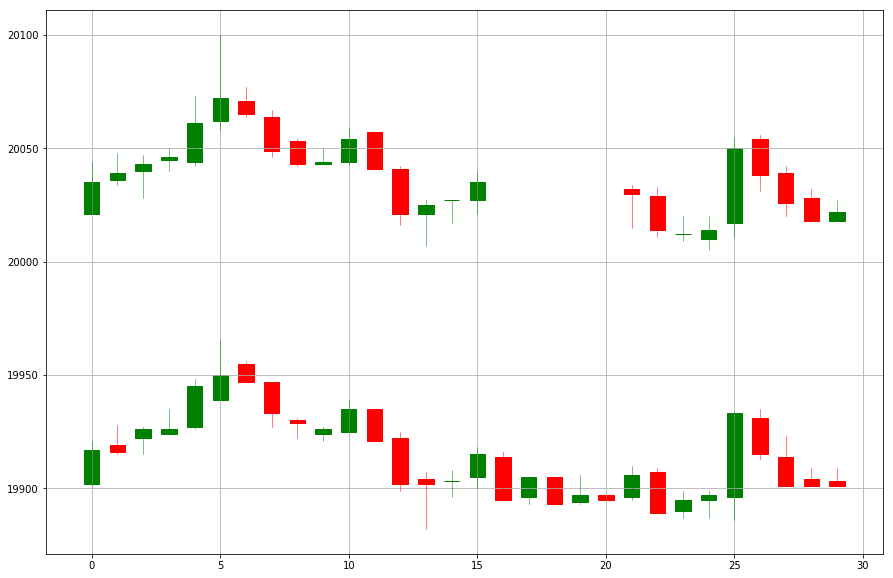

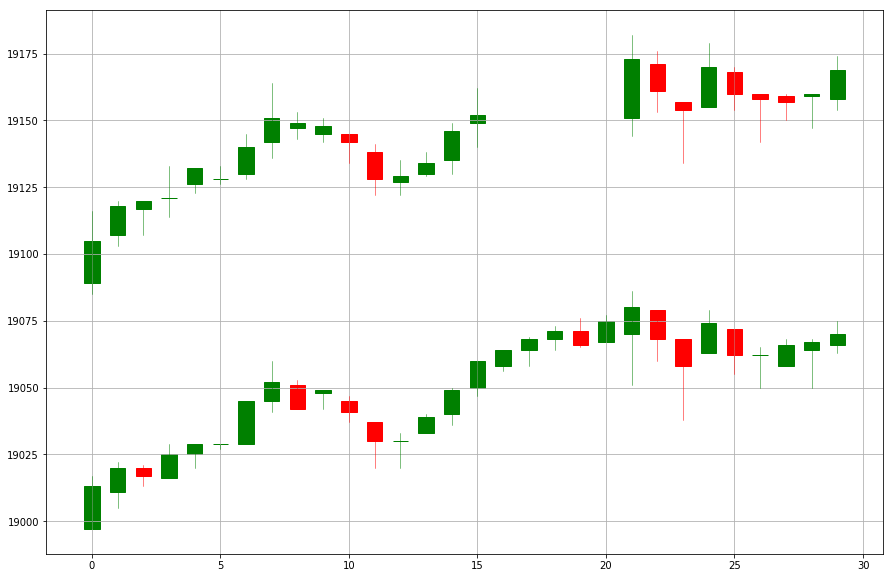

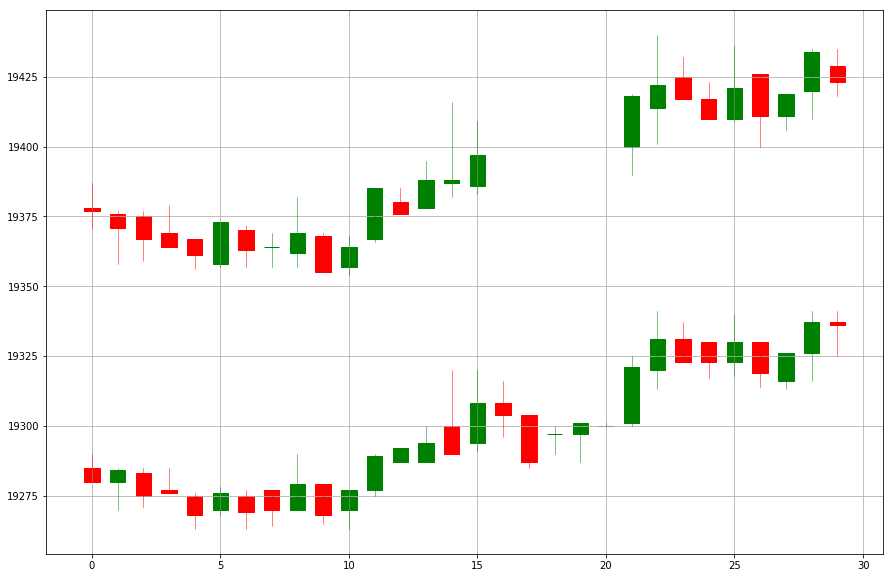

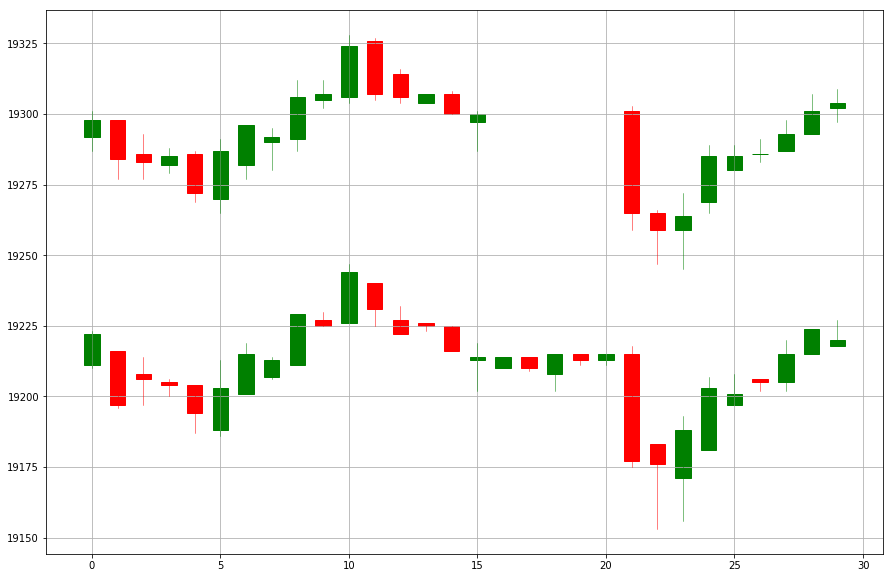

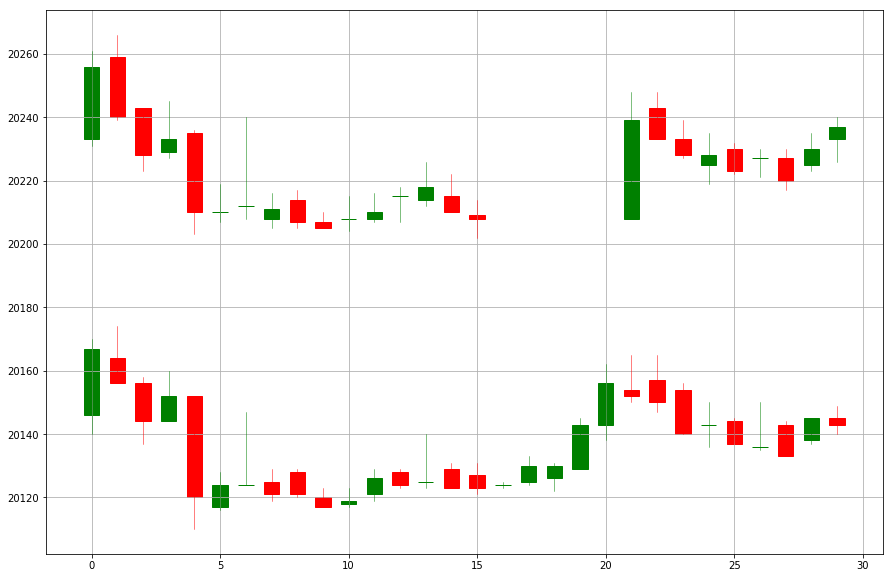

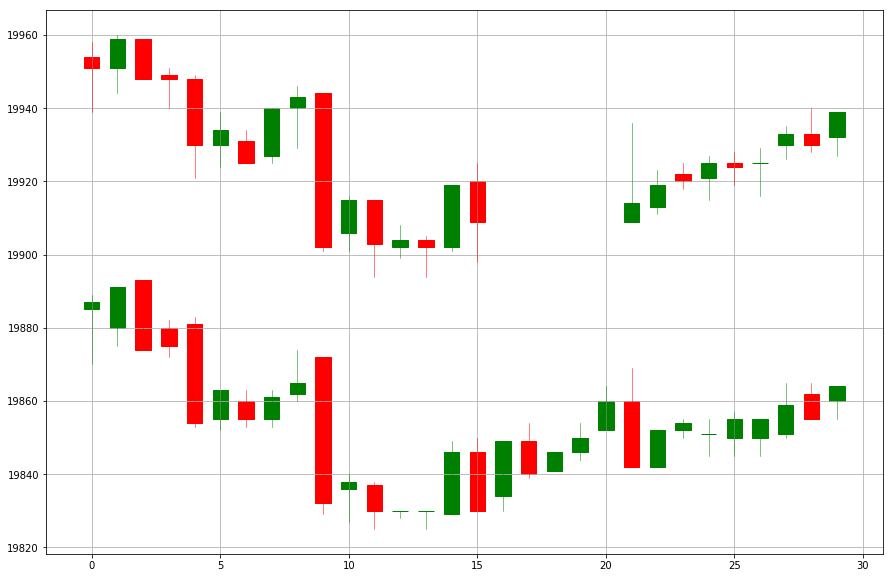

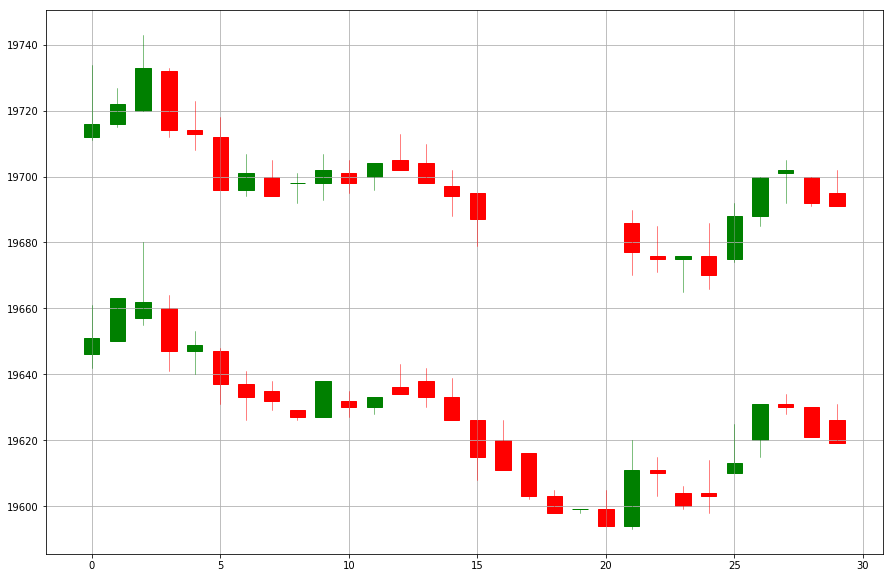

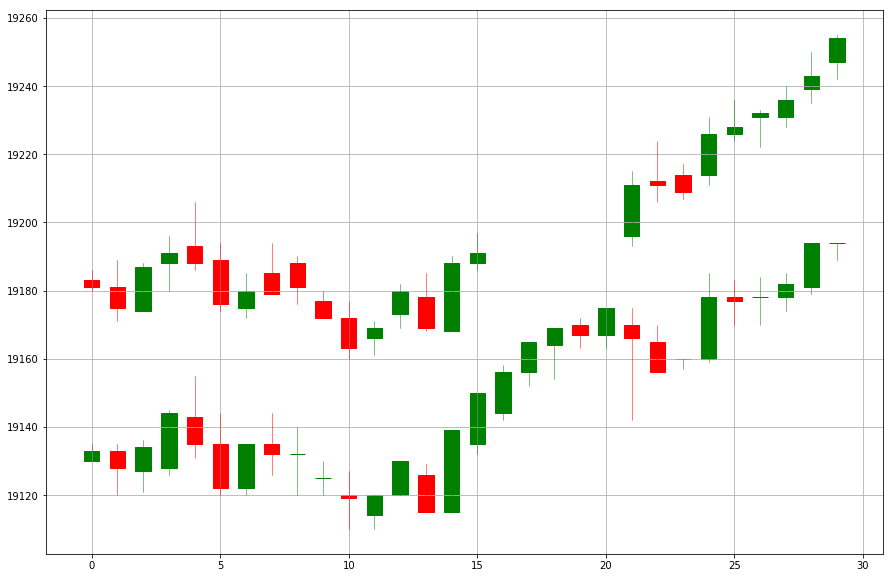

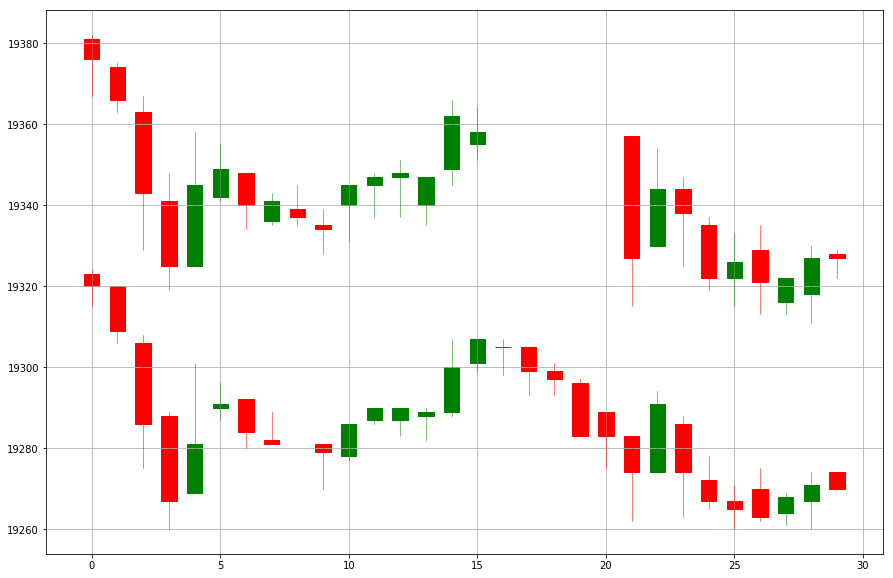

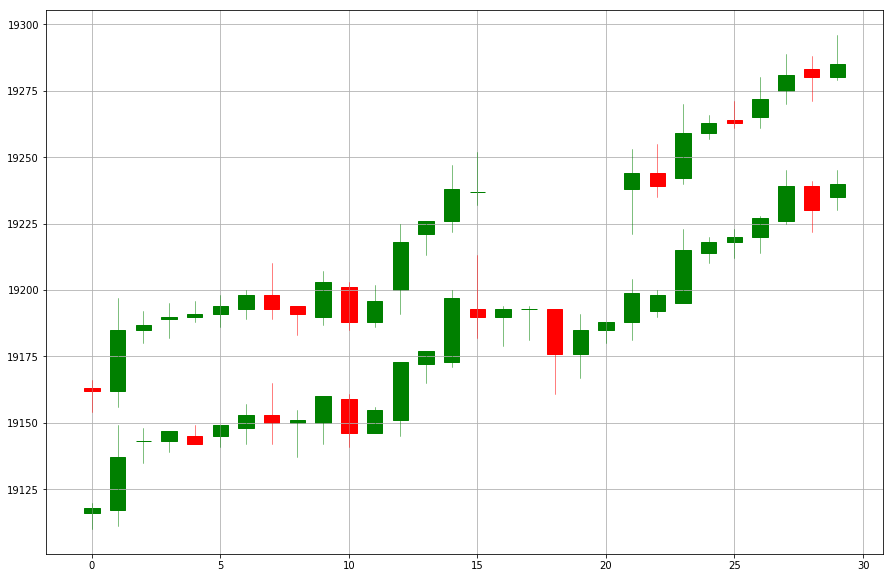

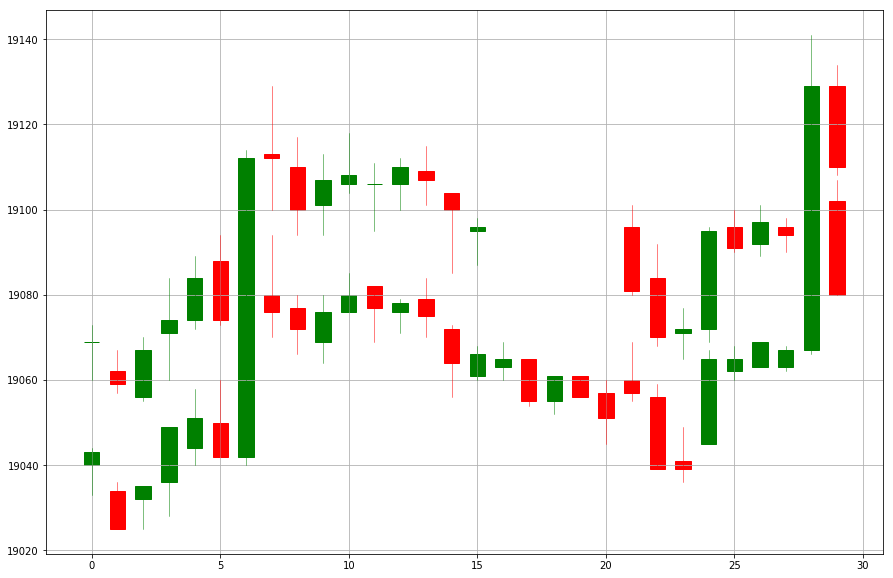

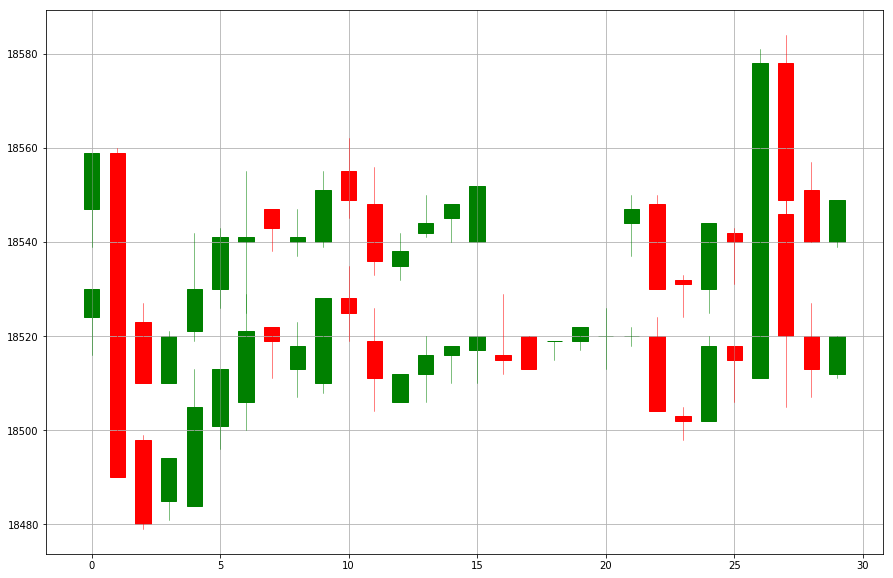

In [27]:
for k, v in gb:
    around_clearing = v.between_time('13:45','14:14')
    print(k)
    #ax = around_clearing.plot(figsize=(20/2,10/2), style='o', markersize=4)
    f1, ax = plt.subplots(figsize = (15,10))
    candlestick_ohlc(ax, around_clearing.iloc[:,:4].reset_index(drop=True).reset_index().values, width=.6, colorup='green', colordown='red')
    candlestick_ohlc(ax, around_clearing.iloc[:,4:].reset_index(drop=True).reset_index().values, width=.6, colorup='green', colordown='red')
    ax.grid(which='both')

In [10]:
x

NameError: name 'x' is not defined

In [ ]:
pandas.Timestamp(ts_input=x.index[0].date(), hour=13, minute=30)

In [ ]:
fut_late = fut[fut.DATETIME.apply(lambda x: x.hour)>18]

In [ ]:
late_ohlc = fut_late.CLOSE.groupby(fut_late.DATETIME.apply(lambda x: x.date())).ohlc()
late_vols = fut_late.VOL.groupby(fut_late.DATETIME.apply(lambda x: x.date())).sum()

In [ ]:
late_input = late_ohlc
late_input['vol'] = late_vols
late_moves_and_vol = late_ohlc.iloc[:,1:-1].div(late_ohlc.open, axis=0) -1
late_moves_and_vol['vol'] = late_vols

In [ ]:
spot_intro = spot[spot.DATETIME.apply(lambda x: x.hour)<12]
spot_intro_ohlc = spot_intro.CLOSE.groupby(spot_intro.DATETIME.apply(lambda x: x.date())).ohlc()
intro_max_moves=pandas.DataFrame({'worst_move': spot_intro_ohlc.low/spot_intro_ohlc.open-1,
                                  'best_move': spot_intro_ohlc.high/spot_intro_ohlc.open-1})
intro_close_moves = spot_intro_ohlc.close/spot_intro_ohlc.open - 1

In [ ]:
data = late_moves_and_vol
data['next_day_spot_intro_move'] = intro_close_moves.shift(-1)
data.dropna(inplace=True)

In [ ]:
filtered = data[(data.vol > data.vol.quantile(0.5))]

In [ ]:
filtered[['close','next_day_spot_intro_move']].plot()

In [ ]:
data.plot.scatter(x='close',y='next_day_spot_intro_move')

In [ ]:
merged = pandas.merge(fut.set_index('DATETIME')[['CLOSE']],
                      spot.set_index('DATETIME')[['CLOSE']],
                      on='DATETIME',
                      how='left',
                      suffixes=('_fut', '_spot'))
merged.fillna(method='ffill', inplace=True)
merged['CLOSE_spot'] = merged['CLOSE_spot']*100

In [ ]:
for_plot = merged
for_plot['DIFF'] = (for_plot['CLOSE_fut']-for_plot['CLOSE_spot'])

In [ ]:
'''
for_plot = merged.iloc[-800:-300]
ax = (for_plot['CLOSE_y']-for_plot['CLOSE_x']).plot(figsize=(20,10), style='o', markersize=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
'''

In [ ]:
fut.CLOSE.iloc[-800:-300].plot()

In [ ]:
plot_multi(for_plot.iloc[-16100:-15800], cols=['CLOSE_fut', 'CLOSE_spot'], figsize=(20,10))

In [ ]:
(for_plot.iloc[-16100:-15800].DIFF/100 - for_plot.iloc[-16100:-15800].mean()/100).plot()

In [ ]:
(for_plot.iloc[-16100:-15800].DIFF/100 - for_plot.iloc[-16100:-15800].DIFF.mean()/100).plot()